#### Claim Label Classification

Recall that the goal of this project is to design and implement a system that takes a given `claim` and then retrieves (one or more) `evidence passages` from a document store, then using these evidence passages classifies the claim as one of these four labels: `[SUPPORTS, REFUTES, NOT_ENOUGH_INFO, DISPUTED]. 

Our first step will be to use train a simple BERT based clasifier which takes as input a sequence containing a `(claim, single evidence passage)` pair in the format: `[CLS] claim text [SEP] evidence text [SEP]`and classifies it by passing the `[CLS]` output embedding to a softmax classifier. If for a given claim `c`, if we have multiple evidence passages `[e_1, e_2, .., e_n]`, then we will have separate input pairs `(c, e_1)`, .., `(c, e_n)` all of which are assigned the same label. Then during inference time, given that we have multiple evidence passages and a claim, we classify every pair `(c,e_i)` and take a majority vote of the label. Note that this model assumes that the multiple evidences passages for a single claim independently determine the class label, which may not be true in some cases where the different evidences can interact in some complex way to determine the label. 

The next step will be to aggregate all the evidence passgaes into a single passage and classify input sequence containing `(claim, aggregated evidence passages)`. The simplest form of aggregation would be to directly concatenate all the input evidence passages into a single passage. Howevere, due to the maximum input sequence length imposed by BERT, we may need to do some truncation of these passages. This model will be able to learn the interactions between the different evidence passages which may lead to improved performance.


In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from tqdm import tqdm
import random, psutil, os
from DPR_biencoder_simple import *
from utils import *
import matplotlib.pyplot as plt
import wandb

%load_ext autoreload
%autoreload 2

wandb.login()
print(torch.cuda.is_available())

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tanzids. Use `wandb login --relogin` to force relogin


True


Number of evidence passages: 1208827
Number of training instances: 1228
Number of validation instances: 154
Number of evidence passages remaining after cleaning: 1204715


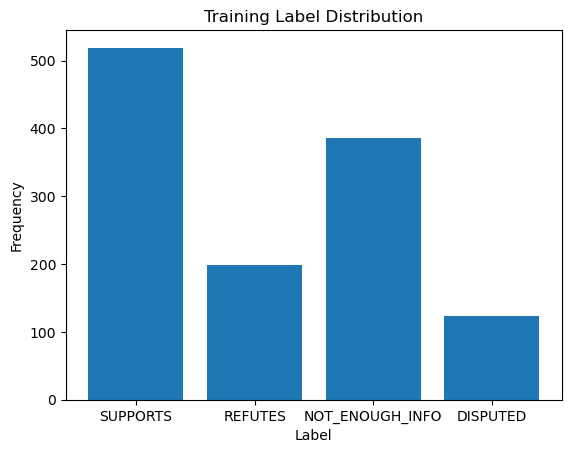

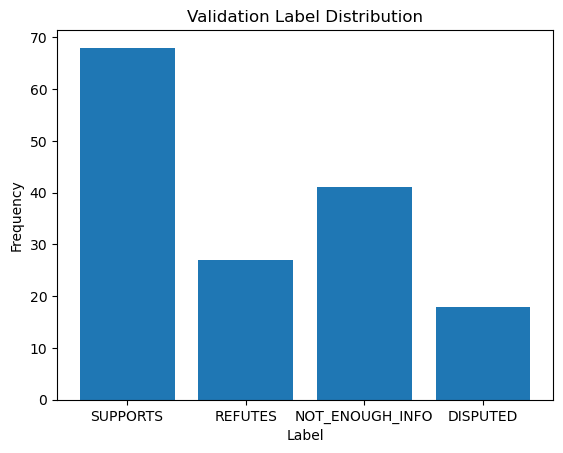

In [2]:
# first let's load the data and look at some examples and the label distribution
label_dict = {'SUPPORTS':0, 'REFUTES':1, 'NOT_ENOUGH_INFO':2, 'DISPUTED':3}
document_store, train_data, val_data = load_data(clean=True, clean_threshold=30)
train_labels = [label_dict[claim['claim_label']] for claim_id, claim in train_data.items()]
val_labels = [label_dict[claim['claim_label']] for claim_id, claim in val_data.items()]

# plot label distribution bar chart
label_counts = [train_labels.count(i) for i in range(4)]
labels = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'DISPUTED']

plt.bar(labels, label_counts)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Training Label Distribution')
plt.show()

label_counts = [val_labels.count(i) for i in range(4)]
plt.bar(labels, label_counts)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Validation Label Distribution')
plt.show()

The distribution is slightly imbalanced, with much fewer instances for labels REFUTES and DISPUTED 

In [3]:
# show some examples of claims, evidence, and labels
c = random.sample(list(train_data.items()), 10)
for claim_id, claim in c:
    print(f"\n{claim_id} --> {claim['claim_text']}")
    print(f"Evidences:")
    for ev in claim['evidences']:
        print(f"\t{document_store[ev]}")
    print(f"Claim Label: {claim['claim_label']}")


claim-2049 --> The Millennium Drought starting in 1997 and ending in 2010 was misinterpreted as a long term trend as a consequence of Climate Change.
Evidences:
	Climate change occurs when changes in Earth's climate system result in new weather patterns that remain in place for an extended period of time.
	The long Australian Millennial drought broke in 2010.
	In addition, many areas are experiencing higher than normal droughts.
Claim Label: SUPPORTS

claim-3122 --> Yet clouds reflect about seventy-five watts per square meter.
Evidences:
	If the extraterrestrial solar radiation is 1367 watts per square meter (the value when the Earth–Sun distance is 1 astronomical unit), then the direct sunlight at Earth's surface when the Sun is at the zenith is about 1050 W/m2, but the total amount (direct and indirect from the atmosphere) hitting the ground is around 1120 W/m2.
	Dividing the irradiance of 1050 W/m2 by the size of the Sun's disk in steradians gives an average radiance of 15.4 MW per

Note: The DISPUTED label is typically assigned when when the evidences contain conflicting ideas.

#### Pytorch Dataset

In [4]:
# set tokenizer parallelism to False
os.environ["TOKENIZERS_PARALLELISM"] = "false"  

# single evidence dataset
class ClaimsDatasetSingle(Dataset):
    def __init__(self, claims_data, document_store, label_dict, block_size=192):
        self.claims_data = claims_data
        self.document_store = document_store
        self.label_dict = label_dict
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.block_size = block_size
        self.claim_pairs = self.create_pairs()

    def create_pairs(self):
        claim_pairs = []
        for claim_id in self.claims_data.keys():
            for evidence_id in self.claims_data[claim_id]['evidences']:
                claim_pairs.append((claim_id, evidence_id))  
        return claim_pairs

    def __len__(self):
        return len(self.claim_pairs)

    def __getitem__(self, idx):
        # get claim id and evidence id
        claim_id, evidence_id = self.claim_pairs[idx]
        target_label = self.label_dict[self.claims_data[claim_id]['claim_label']]
        # get the claim and evidence text
        claim_text = self.claims_data[claim_id]['claim_text']
        evidence_text = self.document_store[evidence_id]
        # encode and create tensors
        #input_idx, input_attn_mask, token_type_idx = self.tokenize_and_encode(claim_text, evidence_text)
        input_idx, input_attn_mask = self.tokenize_and_encode(claim_text, evidence_text)
        target_label = torch.tensor(target_label)
        #return input_idx, input_attn_mask, token_type_idx, target_label
        return input_idx, input_attn_mask, target_label

    def tokenize_and_encode(self, claim_text, evidence_text):
        # tokenize the claim and evidence text  
        claim_encoding = self.tokenizer.encode_plus(claim_text, add_special_tokens=False, return_offsets_mapping=False, return_attention_mask=False, return_token_type_ids=False)
        claim_idx = claim_encoding['input_ids']
        evidence_encoding = self.tokenizer.encode_plus(evidence_text, add_special_tokens=False, return_offsets_mapping=False, return_attention_mask=False, return_token_type_ids=False)
        evidence_idx = evidence_encoding['input_ids']

        # select a random window from the evidence passage if it won't fit in block size
        max_evidence_size = self.block_size - len(claim_idx) - 3
        if len(evidence_idx) > max_evidence_size:
            # pick a random start position
            start_pos = random.randint(0, max(0,len(evidence_idx)-max_evidence_size))
            # select the window
            evidence_idx = evidence_idx[start_pos:start_pos+max_evidence_size]
 
        # concatenate the claim and evidence, add special tokens and padding
        input_idx = [self.tokenizer.cls_token_id] + claim_idx + [self.tokenizer.sep_token_id] + evidence_idx + [self.tokenizer.sep_token_id]
        input_idx = input_idx + [self.tokenizer.pad_token_id] * (self.block_size - len(input_idx))    

        # create segment ids
        #claim_len = len(claim_idx) + 2
        #evidence_len = len(evidence_idx) + 1
        #token_type_idx = [0] * claim_len + [1] * evidence_len + [0] * (self.block_size - claim_len - evidence_len)

        # make sure the passage sequences and claim sequences are not longer than max_length
        if len(input_idx) > self.block_size:
            raise Exception(f"Input sequence length {len(input_idx)} is longer than max_length {self.block_size}!")
    
        # create attention masks
        input_attn_mask = [1 if idx != self.tokenizer.pad_token_id else 0 for idx in input_idx]
        # convert to tensors
        input_idx = torch.tensor(input_idx)
        input_attn_mask = torch.tensor(input_attn_mask)
        #token_type_idx = torch.tensor(token_type_idx)  # don't need this for roberta

        return input_idx, input_attn_mask #, token_type_idx


# aggregated evidences dataset
class ClaimsDatasetAggregate(Dataset):
    def __init__(self, claims_data, document_store, label_dict, block_size=192):
        self.claims_data = list(claims_data.items())
        self.document_store = document_store
        self.label_dict = label_dict
        #self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.block_size = block_size

    def __len__(self):
        return len(self.claims_data)

    def __getitem__(self, idx):
        # get claim and evidence texts
        claim_id, claim = self.claims_data[idx]
        claim_text = claim['claim_text']
        evidences_text = [self.document_store[evidence_id] for evidence_id in claim['evidences']]
        target_label = self.label_dict[claim['claim_label']]
        # encode and create tensors
        #input_idx, input_attn_mask, token_type_idx = self.tokenize_and_encode(claim_text, evidences_text)
        input_idx, input_attn_mask = self.tokenize_and_encode(claim_text, evidences_text)
        target_label = torch.tensor(target_label)
        #return input_idx, input_attn_mask, token_type_idx, target_label
        return input_idx, input_attn_mask, target_label

    def tokenize_and_encode(self, claim_text, evidences_text):
        # tokenize the claim and evidence text  
        claim_encoding = self.tokenizer.encode_plus(claim_text, add_special_tokens=False, return_offsets_mapping=False, return_attention_mask=False, return_token_type_ids=False)
        claim_idx = claim_encoding['input_ids']
        evidence_encoding = self.tokenizer.batch_encode_plus(evidences_text, add_special_tokens=False, return_offsets_mapping=False, return_attention_mask=False, return_token_type_ids=False)
        evidence_idx = evidence_encoding['input_ids']

        # take a separate random window from each evidence passage, make sure the window proportions are the same, and that it fits in max_evidence_size
        total_evidence_length = sum([len(evidence) for evidence in evidence_idx])
        max_evidence_size = self.block_size - len(claim_idx) - 3
        if total_evidence_length > max_evidence_size:
            windowed_evidence_idx = []
            for evidence in evidence_idx:
                desired_length = max_evidence_size*len(evidence)//total_evidence_length
                # pick a random start position
                start_pos = random.randint(0, max(0,len(evidence)-desired_length))
                # select the window
                evidence = evidence[start_pos:start_pos+desired_length]
                windowed_evidence_idx.append(evidence)
            evidence_idx = windowed_evidence_idx

        # concatenate the evidences
        evidence_idx = [idx for evidence in evidence_idx for idx in evidence] 
                  
        # concatenate the claim and evidence, add special tokens and padding
        input_idx = [self.tokenizer.cls_token_id] + claim_idx + [self.tokenizer.sep_token_id] + evidence_idx + [self.tokenizer.sep_token_id]
        input_idx = input_idx + [self.tokenizer.pad_token_id] * (self.block_size - len(input_idx))    

        # create segment ids
        #claim_len = len(claim_idx) + 2
        #evidence_len = len(evidence_idx) + 1
        #token_type_idx = [0] * claim_len + [1] * evidence_len + [0] * (self.block_size - claim_len - evidence_len)

        # make sure the passage sequences and claim sequences are not longer than max_length
        if len(input_idx) > self.block_size:
            raise Exception(f"Input sequence length {len(input_idx)} is longer than max_length {self.block_size}!")
    
        # create attention masks
        input_attn_mask = [1 if idx != self.tokenizer.pad_token_id else 0 for idx in input_idx]
        # convert to tensors
        input_idx = torch.tensor(input_idx)
        input_attn_mask = torch.tensor(input_attn_mask)
        #token_type_idx = torch.tensor(token_type_idx)  # don't need this for roberta

        return input_idx, input_attn_mask #, token_type_idx

#### Classifier Model

In [5]:
class ClaimClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.1):
        super().__init__()
        # load pretrained BERT model
        #self.bert_encoder = BertModel.from_pretrained('bert-base-uncased')
        self.bert_encoder = RobertaModel.from_pretrained('roberta-base')
        self.dropout = torch.nn.Dropout(dropout_rate)
        # define classifier head
        self.classifier_head = torch.nn.Linear(768, 4)
        # make sure BERT parameters are trainable
        for param in self.bert_encoder.parameters():
            param.requires_grad = True

    #def forward(self, input_idx, input_attn_mask, token_type_idx, targets=None):
    def forward(self, input_idx, input_attn_mask, targets=None):
        # compute BERT encodings, extract the pooler output (which is just the [CLS] embedding fed through a feedforward network or just the [CLS] embedding), apply dropout        
        #bert_output = self.bert_encoder(input_idx, attention_mask=input_attn_mask, token_type_ids=token_type_idx)
        bert_output = self.bert_encoder(input_idx, attention_mask=input_attn_mask)
        pooled_output = self.dropout(bert_output.last_hidden_state[:,0]) # shape: (batch_size, hidden_size)
        #pooled_output = self.dropout(bert_output.pooler_output) # shape: (batch_size, hidden_size)
        # compute output logits
        logits = self.classifier_head(pooled_output) # shape: (batch_size, 4)
        # compute cross-entropy loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits, targets)
        return logits, loss


# training loop
def train(model, optimizer, train_dataloader, val_dataloader, scheduler=None, device="cpu", num_epochs=10, val_every=100, save_every=None, log_metrics=None):
    avg_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    model.train()
    # reset gradients
    optimizer.zero_grad()
    for epoch in range(num_epochs):
        num_correct = 0
        num_total = 0
        pbar = tqdm(train_dataloader, desc="Epochs")
        for i, batch in enumerate(pbar):
            #input_idx, input_attn_mask, token_type_idx, targets = batch
            input_idx, input_attn_mask, targets = batch
            # move batch to device
            #input_idx, input_attn_mask, token_type_idx, targets = input_idx.to(device), input_attn_mask.to(device), token_type_idx.to(device), targets.to(device)
            input_idx, input_attn_mask, targets = input_idx.to(device), input_attn_mask.to(device), targets.to(device)
            # forward pass
            #logits, loss = model(input_idx, input_attn_mask, token_type_idx, targets)
            logits, loss = model(input_idx, input_attn_mask, targets)
            # reset gradients
            optimizer.zero_grad()
            # backward pass
            loss.backward()
            # optimizer step
            optimizer.step()

            if scheduler is not None:
                    scheduler.step()

            avg_loss = 0.9* avg_loss + 0.1*loss.item()
            B, _ = input_idx.shape
            y_pred = logits.argmax(dim=-1).view(-1) # shape (B,)
            num_correct += (y_pred.eq(targets.view(-1))).sum().item()      
            num_total += B
            train_acc = num_correct / num_total        

            if val_every is not None:
                if i%val_every == 0:
                    # compute validation loss
                    val_loss, val_acc = validation(model, val_dataloader, device=device)
                    pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            pbar.set_description(f"Epoch {epoch + 1}, EMA Train Loss: {avg_loss:.3f}, Train Accuracy: {train_acc: .3f}, Val Loss: {val_loss: .3f}, Val Accuracy: {val_acc: .3f}")  

            if log_metrics:
                metrics = {"Batch loss":loss.item(), "Moving Avg Loss":avg_loss, "Train Accuracy":train_acc, "Val Loss": val_loss, "Val Accuracy":val_acc}
                log_metrics(metrics)

        if save_every is not None:
            if (epoch+1) % save_every == 0:
                save_model_checkpoint(model, optimizer, epoch, avg_loss)


def validation(model, val_dataloader, device="cpu"):
    model.eval()
    val_losses = torch.zeros(len(val_dataloader))
    with torch.no_grad():
        num_correct = 0
        num_total = 0
        for i,batch in enumerate(val_dataloader):
            #input_idx, input_attn_mask, token_type_idx, targets = batch
            input_idx, input_attn_mask, targets = batch
            #input_idx, input_attn_mask, token_type_idx, targets = input_idx.to(device), input_attn_mask.to(device), token_type_idx.to(device), targets.to(device)
            input_idx, input_attn_mask, targets = input_idx.to(device), input_attn_mask.to(device), targets.to(device)
            #logits, loss = model(input_idx, input_attn_mask, token_type_idx, targets)
            logits, loss = model(input_idx, input_attn_mask, targets)
            B, _ = input_idx.shape
            y_pred = logits.argmax(dim=-1).view(-1) # shape (B,)
            num_correct += (y_pred.eq(targets.view(-1))).sum().item()      
            num_total += B
            val_losses[i] = loss.item()
    model.train()
    val_loss = val_losses.mean().item()
    val_accuracy = num_correct / num_total
    return val_loss, val_accuracy

def save_model_checkpoint(model, optimizer, epoch=None, loss=None, filename=None):
    # Save the model and optimizer state_dict
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    # Save the checkpoint to a file
    if filename:
        torch.save(checkpoint, filename)
    else:
        torch.save(checkpoint, 'classifier_checkpoint.pth')
    print(f"Saved model checkpoint!")



def load_model_checkpoint(model, optimizer=None, filename=None):
    if filename:
        checkpoint = torch.load(filename)
    else:
        checkpoint = torch.load('classifier_checkpoint.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Loaded model from checkpoint!")
    if optimizer:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        model.train()
        return model, optimizer          
    else:
        return model    

#### First, we will train the model using the single evidence pairs

In [6]:
"""block_size = 256
train_dataset = ClaimsDatasetSingle(train_data, document_store, label_dict, block_size=block_size)
val_dataset = ClaimsDatasetSingle(val_data, document_store, label_dict, block_size=block_size)
print(len(train_dataset), len(val_dataset)) """

'block_size = 256\ntrain_dataset = ClaimsDatasetSingle(train_data, document_store, label_dict, block_size=block_size)\nval_dataset = ClaimsDatasetSingle(val_data, document_store, label_dict, block_size=block_size)\nprint(len(train_dataset), len(val_dataset)) '

In [7]:
"""
B = 16
DEVICE = "cuda"
learning_rate = 1e-5

train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)

# model with finetuning disabled
model = ClaimClassifier(dropout_rate=0.1).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
model, optimizer = load_model_checkpoint(model, optimizer)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in transformer network: {num_params/1e6} M")
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")
"""

'\nB = 16\nDEVICE = "cuda"\nlearning_rate = 1e-5\n\ntrain_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)\nval_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)\n\n# model with finetuning disabled\nmodel = ClaimClassifier(dropout_rate=0.1).to(DEVICE)\noptimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)\nscheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)\nmodel, optimizer = load_model_checkpoint(model, optimizer)\n\nnum_params = sum(p.numel() for p in model.parameters())\nprint(f"Total number of parameters in transformer network: {num_params/1e6} M")\nprint(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")\n'

In [8]:
"""run = wandb.init(
    project="Automated Climate Fact Checker", 
    config={
        "bi-encoder model": "BERT",
        "learning_rate": learning_rate, 
        "epochs": 5,
        "batch_size": B, 
        "corpus": "COMP90042 2023 project"},)   

def log_metrics(metrics):
    wandb.log(metrics)"""

'run = wandb.init(\n    project="Automated Climate Fact Checker", \n    config={\n        "bi-encoder model": "BERT",\n        "learning_rate": learning_rate, \n        "epochs": 5,\n        "batch_size": B, \n        "corpus": "COMP90042 2023 project"},)   \n\ndef log_metrics(metrics):\n    wandb.log(metrics)'

In [9]:
#train(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, num_epochs=2, save_every=None, val_every=100, log_metrics=log_metrics) 

In [10]:
"""# now lets recompute the validation accuracy, this time using majority voting over all evidence pairs per claim
model.eval()
with torch.no_grad():
    num_correct = 0
    num_total = 0
    for claim_id, claim in tqdm(val_data.items()):
        claim_text = claim['claim_text']
        evidences = [document_store[evidence_id] for evidence_id in claim['evidences']]
        label = label_dict[claim['claim_label']]
        input_idx_batch = []
        input_attn_mask_batch = []
        token_type_idx_batch = []
        for evidence_text in evidences:
            # encode and create tensors
            input_idx, input_attn_mask, token_type_idx = val_dataset.tokenize_and_encode(claim_text, evidence_text)
            input_idx_batch.append(input_idx)
            input_attn_mask_batch.append(input_attn_mask)
            token_type_idx_batch.append(token_type_idx)
        input_idx_batch = torch.stack(input_idx_batch).to(DEVICE)
        input_attn_mask_batch = torch.stack(input_attn_mask_batch).to(DEVICE)
        token_type_idx_batch = torch.stack(token_type_idx_batch).to(DEVICE)
        logits, loss = model(input_idx_batch, input_attn_mask_batch, token_type_idx_batch)
        y_pred = logits.argmax(dim=-1).view(-1) # shape (num_evidences,)
        # get majority label
        y_pred = y_pred.mode().values.item()
        num_correct += int(y_pred == label)
        num_total += 1

model.train()
val_accuracy = num_correct / num_total
print(f"Validation accuracy with majority voting: {val_accuracy:.3f}")"""

'# now lets recompute the validation accuracy, this time using majority voting over all evidence pairs per claim\nmodel.eval()\nwith torch.no_grad():\n    num_correct = 0\n    num_total = 0\n    for claim_id, claim in tqdm(val_data.items()):\n        claim_text = claim[\'claim_text\']\n        evidences = [document_store[evidence_id] for evidence_id in claim[\'evidences\']]\n        label = label_dict[claim[\'claim_label\']]\n        input_idx_batch = []\n        input_attn_mask_batch = []\n        token_type_idx_batch = []\n        for evidence_text in evidences:\n            # encode and create tensors\n            input_idx, input_attn_mask, token_type_idx = val_dataset.tokenize_and_encode(claim_text, evidence_text)\n            input_idx_batch.append(input_idx)\n            input_attn_mask_batch.append(input_attn_mask)\n            token_type_idx_batch.append(token_type_idx)\n        input_idx_batch = torch.stack(input_idx_batch).to(DEVICE)\n        input_attn_mask_batch = torch.st

#### The classification accuracy on the validation dataset using single evidence input and majority voting is about 54%. Now let's train the model with the aggregated evidence input, we will also increase the block_size of our input sequences.

In [11]:
block_size = 320
train_dataset = ClaimsDatasetAggregate(train_data, document_store, label_dict, block_size=block_size)
val_dataset = ClaimsDatasetAggregate(val_data, document_store, label_dict, block_size=block_size)
print(len(train_dataset), len(val_dataset)) 

1228 154


In [12]:
B = 16
DEVICE = "cuda"
learning_rate = 2e-5
epochs = 6

train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True, pin_memory=True, num_workers=2)

# model with finetuning disabled
model = ClaimClassifier(dropout_rate=0.1).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
total_steps = len(train_dataloader) * epochs 
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=80, num_training_steps=total_steps)
model, optimizer = load_model_checkpoint(model, optimizer)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in transformer network: {num_params/1e6} M")
print(f"RAM used: {psutil.Process().memory_info().rss / (1024 * 1024):.2f} MB")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total number of parameters in transformer network: 124.648708 M
RAM used: 2998.39 MB


In [13]:
run = wandb.init(
    project="Automated Climate Fact Checker", 
    config={
        "bi-encoder model": "BERT",
        "learning_rate": learning_rate, 
        "epochs": 5,
        "batch_size": B, 
        "corpus": "COMP90042 2023 project"},)   

def log_metrics(metrics):
    wandb.log(metrics)

In [14]:
train(model, optimizer, train_dataloader, val_dataloader, device=DEVICE, num_epochs=epochs, scheduler=scheduler, save_every=None, val_every=20, log_metrics=log_metrics) 

Epochs:   0%|          | 0/77 [00:00<?, ?it/s]

Epoch 1, EMA Train Loss: 1.090, Train Accuracy:  0.396, Val Loss:  1.203, Val Accuracy:  0.578: 100%|██████████| 77/77 [02:25<00:00,  1.89s/it]
Epoch 2, EMA Train Loss: 0.887, Train Accuracy:  0.627, Val Loss:  0.868, Val Accuracy:  0.662: 100%|██████████| 77/77 [03:02<00:00,  2.36s/it]
Epoch 3, EMA Train Loss: 0.771, Train Accuracy:  0.673, Val Loss:  0.792, Val Accuracy:  0.662: 100%|██████████| 77/77 [03:04<00:00,  2.39s/it]
Epoch 4, EMA Train Loss: 0.681, Train Accuracy:  0.706, Val Loss:  0.999, Val Accuracy:  0.610: 100%|██████████| 77/77 [03:24<00:00,  2.66s/it]
Epoch 5, EMA Train Loss: 0.588, Train Accuracy:  0.772, Val Loss:  0.726, Val Accuracy:  0.760: 100%|██████████| 77/77 [03:28<00:00,  2.71s/it]
Epoch 6, EMA Train Loss: 0.356, Train Accuracy:  0.826, Val Loss:  0.628, Val Accuracy:  0.786: 100%|██████████| 77/77 [03:30<00:00,  2.73s/it]


In [43]:
#save_model_checkpoint(model, optimizer)

Saved model checkpoint!


In [16]:
validation(model, val_dataloader, device=DEVICE)

(0.638003945350647, 0.7922077922077922)

#### As expected, we see improved performance when using aggregated evidences in the input, we get over 10% increase in accuracy on the validation set. 

#### The next step is to create a pipeline connecting the passage retriever with the claim classifier. Instead of using the ground truth evidences for each claim from the validation set, we will draw evidences from the precomputed DPR topk and cross-encoder reranked topk to create a new evidence list based on our retreiver. Then we will classify the claims and see how that affects the classification accuracy compared to when we used the ground truth evidence list. 

In [17]:
# load DPR topk
with open("dpr_embeddings/val_dpr_evidences.pkl", "rb") as f:
    val_dpr_evidences_top500 = pickle.load(f)

# load reranked topk
with open("dpr_embeddings/val_top200_reranked.pkl", "rb") as f:
    val_top200_reranked = pickle.load(f) 

For the retreived evidence list, we will start out by using the top-3 reranked evidences and the top-3 from the DPR evidences. We could choose any number of different combinations, but for simplicity, we choose this particular one. We will aggregated the evidences into a single passage.

In [18]:
reranked_topk=3
dpr_topk=3

model.eval()
num_correct = 0
num_total = 0
for claim_id, claim in tqdm(val_data.items()):
    claim_text = claim['claim_text']
    # pick evidences from reranked and from DPR
    evidence_ids = set(val_top200_reranked[claim_id][:reranked_topk] + val_dpr_evidences_top500[claim_id][0][:dpr_topk])
    evidences_text = [document_store[id] for id in evidence_ids]
    label = label_dict[claim['claim_label']]
    # encode and create tensors
    #input_idx, input_attn_mask, token_type_idx = val_dataset.tokenize_and_encode(claim_text, evidences_text)
    input_idx, input_attn_mask = val_dataset.tokenize_and_encode(claim_text, evidences_text)
    with torch.no_grad():
        #logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE), token_type_idx.view(1,-1).to(DEVICE))
        logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE))
    y_pred = logits.argmax(dim=-1).view(-1) 
    num_correct += int(y_pred.item() == label)
    num_total += 1

val_accuracy = num_correct / num_total
print(f"Validation accuracy with retreived evidences: {val_accuracy:.3f}")    

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:01<00:00, 83.11it/s]

Validation accuracy with retreived evidences: 0.396


With top-3 from reranked and top-3 from dpr passages, we get a classification accuracy of 41%. This is substantially lower than the accuracy from using the ground truth evidence passages.

We can try a few different combinations and see if we can improve on this result.

In [19]:
for reranked_topk, dpr_topk in [(2,0), (3,0), (4,0), (5,0), (0,2), (0,3), (0,4) ,(0,5), (1,1), (1,2), (1,3), (2,1), (3,1), (2,2), (3,2), (2,3), (3,3), (4,4)]:
    model.eval()
    num_correct = 0
    num_total = 0
    for claim_id, claim in tqdm(val_data.items()):
        claim_text = claim['claim_text']
        # pick evidences from reranked and from DPR
        evidence_ids = set(val_top200_reranked[claim_id][:reranked_topk] + val_dpr_evidences_top500[claim_id][0][:dpr_topk])
        evidences_text = [document_store[id] for id in evidence_ids]
        label = label_dict[claim['claim_label']]
        # encode and create tensors
        #input_idx, input_attn_mask, token_type_idx = val_dataset.tokenize_and_encode(claim_text, evidences_text)
        input_idx, input_attn_mask = val_dataset.tokenize_and_encode(claim_text, evidences_text)
        with torch.no_grad():
            #logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE), token_type_idx.view(1,-1).to(DEVICE))
            logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE))
        y_pred = logits.argmax(dim=-1).view(-1) 
        num_correct += int(y_pred.item() == label)
        num_total += 1

    val_accuracy = num_correct / num_total
    print(f"Validation accuracy with reranked top-{reranked_topk} and dpr top-{dpr_topk}: {val_accuracy:.3f}")   

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:01<00:00, 93.64it/s]


Validation accuracy with reranked top-2 and dpr top-0: 0.506


100%|██████████| 154/154 [00:01<00:00, 91.15it/s]


Validation accuracy with reranked top-3 and dpr top-0: 0.455


100%|██████████| 154/154 [00:01<00:00, 90.34it/s]


Validation accuracy with reranked top-4 and dpr top-0: 0.468


100%|██████████| 154/154 [00:01<00:00, 87.32it/s]


Validation accuracy with reranked top-5 and dpr top-0: 0.403


100%|██████████| 154/154 [00:01<00:00, 91.64it/s]


Validation accuracy with reranked top-0 and dpr top-2: 0.506


100%|██████████| 154/154 [00:01<00:00, 92.19it/s]


Validation accuracy with reranked top-0 and dpr top-3: 0.494


100%|██████████| 154/154 [00:01<00:00, 92.27it/s]


Validation accuracy with reranked top-0 and dpr top-4: 0.513


100%|██████████| 154/154 [00:01<00:00, 92.50it/s]


Validation accuracy with reranked top-0 and dpr top-5: 0.396


100%|██████████| 154/154 [00:01<00:00, 93.78it/s]


Validation accuracy with reranked top-1 and dpr top-1: 0.513


100%|██████████| 154/154 [00:01<00:00, 94.88it/s]


Validation accuracy with reranked top-1 and dpr top-2: 0.519


100%|██████████| 154/154 [00:01<00:00, 94.45it/s]


Validation accuracy with reranked top-1 and dpr top-3: 0.526


100%|██████████| 154/154 [00:01<00:00, 93.99it/s]


Validation accuracy with reranked top-2 and dpr top-1: 0.506


100%|██████████| 154/154 [00:01<00:00, 94.67it/s]


Validation accuracy with reranked top-3 and dpr top-1: 0.474


100%|██████████| 154/154 [00:01<00:00, 93.64it/s]


Validation accuracy with reranked top-2 and dpr top-2: 0.506


100%|██████████| 154/154 [00:01<00:00, 95.89it/s]


Validation accuracy with reranked top-3 and dpr top-2: 0.461


100%|██████████| 154/154 [00:01<00:00, 94.81it/s]


Validation accuracy with reranked top-2 and dpr top-3: 0.468


100%|██████████| 154/154 [00:01<00:00, 93.56it/s]


Validation accuracy with reranked top-3 and dpr top-3: 0.396


100%|██████████| 154/154 [00:01<00:00, 91.96it/s]

Validation accuracy with reranked top-4 and dpr top-4: 0.325


#### The highest accuracy on the validation set is about 52%.

#### Let's look at a confusion matrix to get a better idea of how well the classifier is performing.

In [40]:
reranked_topk=1
dpr_topk=3

model.eval()
num_correct = 0
num_total = 0
gold_labels = []
pred_labels = []
for claim_id, claim in tqdm(val_data.items()):
    claim_text = claim['claim_text']
    # pick evidences from reranked and from DPR
    evidence_ids = set(val_top200_reranked[claim_id][:reranked_topk] + val_dpr_evidences_top500[claim_id][0][:dpr_topk])
    evidences_text = [document_store[id] for id in evidence_ids]
    label = label_dict[claim['claim_label']]
    gold_labels.append(label)
    # encode and create tensors
    #input_idx, input_attn_mask, token_type_idx = val_dataset.tokenize_and_encode(claim_text, evidences_text)
    input_idx, input_attn_mask = val_dataset.tokenize_and_encode(claim_text, evidences_text)
    with torch.no_grad():
        #logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE), token_type_idx.view(1,-1).to(DEVICE))
        logits, loss = model(input_idx.view(1,-1).to(DEVICE), input_attn_mask.view(1,-1).to(DEVICE))
    y_pred = logits.argmax(dim=-1).view(-1) 
    pred_labels.append(y_pred.item())
    num_correct += int(y_pred.item() == label)
    num_total += 1

val_accuracy = num_correct / num_total
print(f"Validation accuracy with retreived evidences: {val_accuracy:.3f}")  

  0%|          | 0/154 [00:00<?, ?it/s]

100%|██████████| 154/154 [00:01<00:00, 78.61it/s]

Validation accuracy with retreived evidences: 0.526


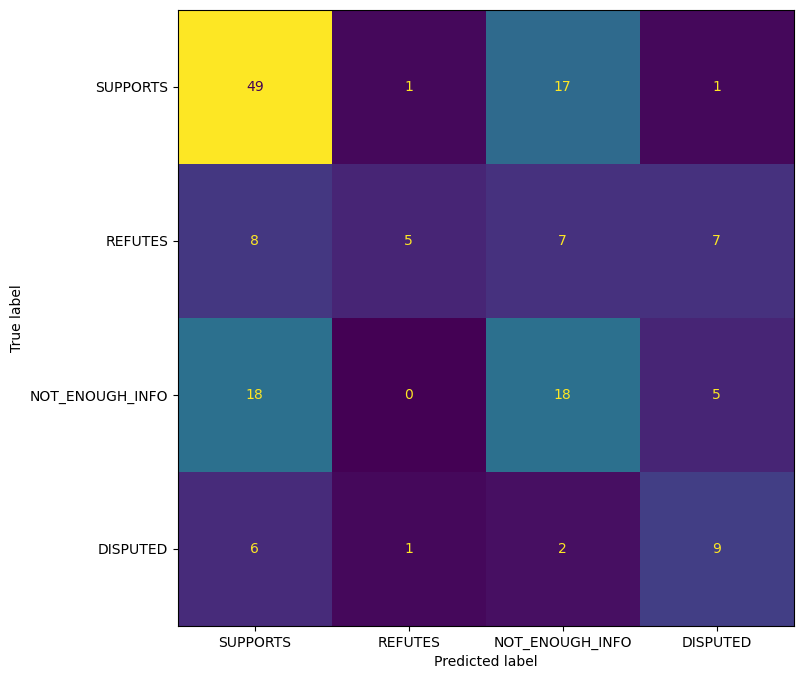

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_names = ['SUPPORTS', 'REFUTES', 'NOT_ENOUGH_INFO', 'DISPUTED']

# plot confusion atrix
disp = ConfusionMatrixDisplay.from_predictions(gold_labels, pred_labels, display_labels=label_names, colorbar=False)
fig = disp.figure_
fig.set_figwidth(8)
fig.set_figheight(8) 

In [42]:
# compute precision, recall, and f1 per class
cm = confusion_matrix(gold_labels, pred_labels)
print(cm)
precision = cm.diagonal()/cm.sum(axis=0)
recall = cm.diagonal()/cm.sum(axis=1)
f1 = 2*precision*recall/(precision+recall)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")


[[49  1 17  1]
 [ 8  5  7  7]
 [18  0 18  5]
 [ 6  1  2  9]]
Precision: [0.60493827 0.71428571 0.40909091 0.40909091]
Recall: [0.72058824 0.18518519 0.43902439 0.5       ]
F1: [0.65771812 0.29411765 0.42352941 0.45      ]
